In [1]:
# Import the required libraries
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from sqlite3 import Error
import sqlalchemy
from sqlalchemy import create_engine
%matplotlib inline

# Functions & Programs
def create_connection(db_file):
    """ create a database connection to a SQLite database """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        print(sqlite3.version)
    except Error as e:
        print(e)
    finally:
        if conn:
            conn.close()

No ideal function that matches test data found. Maximum deviations are too high.
2.6.0


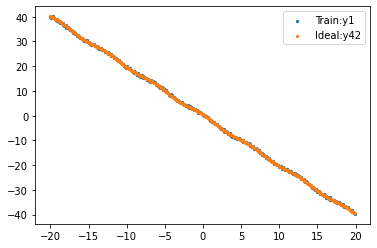

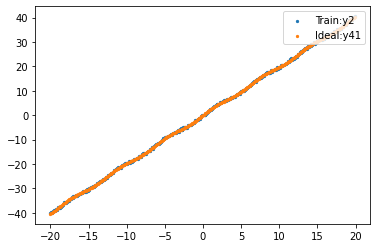

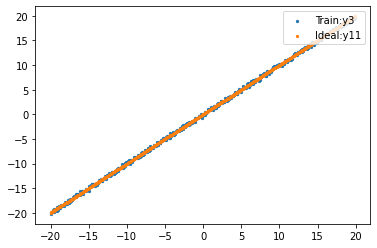

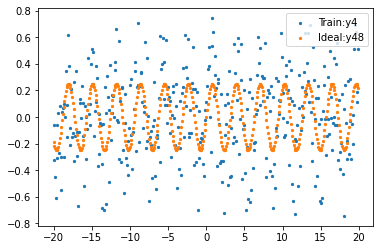

In [2]:
# Import data
test = pd.read_csv('C:\\Users\\DMA Analytics\\Desktop\\Masters\\Python\\Datasets1\\test.csv')
train = pd.read_csv('C:\\Users\\DMA Analytics\\Desktop\\Masters\\Python\\Datasets1\\train.csv')
ideal = pd.read_csv('C:\\Users\\DMA Analytics\\Desktop\\Masters\\Python\\Datasets1\\ideal.csv')

# Choose best fit of ideal functions for train dataset
mses = {}
for y in train:
    if y != 'x':
        errors = {}
        for x in ideal:
            if x != 'x':
                Y = train[y]
                X = ideal[x]
                X = sm.add_constant(X)
                model = sm.OLS(Y, X).fit()
                errors[x] = model.mse_resid
        mses[y] = min(errors, key=errors.get)
        
# Get Maximum deviation of ideal functions from training data
mdev = {}
select = train.merge(ideal[[y for x in [list(mses.values()), 'x'] for y in x]], on='x', how='left')
for item in mses:
    select[item + '_' + mses[item]] = select[item] - select[mses[item]]
    mdev[mses[item]] = select[item + '_' + mses[item]].max()*np.sqrt(2)
    
# Validate if testing data can be matched to any ideal function
tested = test.merge(ideal[[y for x in [list(mses.values()), 'x'] for y in x]], on='x', how='left')
devs = {}
for y in tested:
    if (y != 'x') & (y != 'y'):
        devs[y] = np.diff(tested[[y, 'y']], axis=1).max()
comply = {}
for y in devs:
    if devs[y] <= mdev[y]:
        comply[y] = devs[y]       
if comply:
    print("Ideal function that matches test data is: " + y)
    tested = tested[['x', 'y', min(comply, key=comply.get)]]
    tested['delta'] = tested['y'] - tested[min(comply, key=comply.get)]
else:
    print("No ideal function that matches test data found. Maximum deviations are too high.")
    tested = tested[['x', 'y']]

# Export tables to SQLite database
if __name__ == '__main__':
    create_connection(r"C:\Users\DMA Analytics\Desktop\Masters\Python\sqlite\pythonsqlite.db")
engine = sqlalchemy.create_engine('sqlite:///C:\\Users\\DMA Analytics\\Desktop\\Masters\\Python\\sqlite\\pythonsqlite.db', echo=False)
train.to_sql('train', con=engine, if_exists='append')
ideal.to_sql('ideal', con=engine, if_exists='append')
tested.to_sql('tested', con=engine, if_exists='append')

# Data Visualizations - Ideal & Train functions
for item in mses.items():
    x = train['x']
    y1 = train[item[0]]
    y2 = ideal[item[1]]
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.scatter(x, y1, label='Train:' + item[0],  s=5)
    ax1.scatter(x, y2, label='Ideal:' + item[1],  s=5)
    plt.legend(loc='upper right')
    plt.show()